In [1]:
import torchvision
from torchvision import transforms
import os

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 获取当前工作目录
current_dir = os.getcwd()

# 回到上一级（code），然后上一级（项目根目录），然后进入datasets
dataset_dir = os.path.abspath(os.path.join(
    current_dir, 
    '..', '..',  # 向上两级到达项目根目录
    'datasets', 'cifar-10-python'
))

print("数据集路径:", dataset_dir)

train_set = torchvision.datasets.CIFAR10(
    root=dataset_dir, 
    train=True,
    download=True,
    transform=train_transform
)

test_set = torchvision.datasets.CIFAR10(
    root=dataset_dir, 
    train=False,
    download=True,
    transform=val_transform
)

数据集路径: f:\1111ScientificResearch\classification\datasets\cifar-10-python
Files already downloaded and verified
Files already downloaded and verified


In [2]:
print(len(train_set))

50000


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


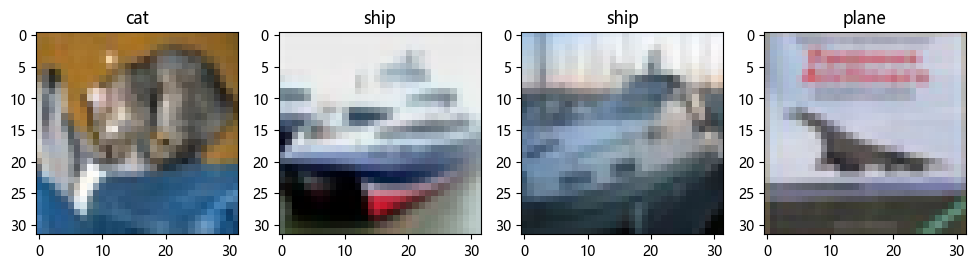

In [16]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig, axes = plt.subplots(1, 4, figsize=(12,3))
for i in range(4):
    img, label = test_set[i]
    print(img.shape)
    axes[i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # 反标准化
    axes[i].set_title(classes[label])
plt.show()

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from CBAM import cbam

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 输入3通道，输出32通道
        self.pool = nn.MaxPool2d(2, 2)                # 下采样
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)         # 32x32 -> 16x16 -> 8x8
        self.fc2 = nn.Linear(256, 10)                 # 输出10类
        self.cbam1 = cbam(in_channel=32)
        self.cbam2 = cbam(in_channel=64)

    def forward(self, x):
        x = F.relu(self.conv1(x))     # [32, 32, 32]
        # x = x + self.cbam1(x)
        x = self.pool(x)               # [32, 16, 16]
        x = F.relu(self.conv2(x))      # [64, 16, 16]
        # x = x + self.cbam2(x)
        x = self.pool(x)               # [64, 8, 8]
        x = x.view(-1, 64 * 8 * 8)     # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [7]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import torch.optim as optim
from torchvision.models import resnet18
import torch
matplotlib.rc("font", family='Microsoft YaHei')
# from Grad_cam import GradCAM, show_cam_on_image, center_crop_img
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10_CNN().to(device)

# model = resnet18(pretrained=True).to(device)
# model.fc = nn.Linear(model.fc.in_features, 10)  # 替换最后一层
# model = model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def model_train(epochs, train_loader, test_loader,model, optimizer,loss_function):
    patience = 10
    no_improve = 0
    best_val_loss = float('inf')
    model = model.to(device)
    train_size = len(train_loader.dataset)
    test_size = len(test_loader.dataset)
    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model
    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    test_acc = []
    test_loss = []
    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for inputs, labels in train_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            # print(inputs.shape)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(inputs)  # 得到预测

            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss_cls = loss_function(y_pred, labels)
            loss =loss_cls 
             # 反向传播
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
        # break 
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} loss_cls:{loss_cls} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            model.eval()
            loss_validate = 0.
            correct_validate = 0
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss_cls = loss_function(pre, label)
                loss = loss_cls 
                loss_validate += loss.item()
            val_loss = loss_validate / test_size
            val_accuracy = correct_validate / test_size
            
            model.train()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            
            print(f'Epoch: {epoch+1:2} loss_cls:{loss_cls} val_Loss:{loss_validate/test_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            test_loss.append(loss_validate/test_size)
            test_acc.append(val_accuracy)

            # 在训练循环内
            if (epoch+1) % 5 == 0:
                print(f'当前学习率: {optimizer.param_groups[0]["lr"]:.2e}')
                print(f'GPU显存占用: {torch.cuda.memory_allocated()/1e9:.2f} GB')
                    
            # 综合损失与准确率保存最佳模型
            if val_loss < best_val_loss or (val_loss == best_val_loss and val_accuracy > best_accuracy):
                best_val_loss = val_loss
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), 'best_model.pth')
                no_improve = 0
            else:
                no_improve += 1
                
            # 早停判断
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    actual_epochs = len(train_loss)
    plt.plot(range(actual_epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(actual_epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(actual_epochs), test_loss, color = 'y',label = 'test_loss')
    plt.plot(range(actual_epochs), test_acc, color = 'r',label = 'test_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)

epochs = 20
# 模型训练
model_train(epochs, train_loader,test_loader,model,optimizer, loss_function)

KeyboardInterrupt: 

In [8]:
def count_parameters(model):
    
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    # for item in params:
    #     print(f'{item:>6}')
    print(f'______\n总参数:{sum(params):>6}')

count_parameters(model)


______
总参数:1073550


In [8]:
from sklearn.metrics import confusion_matrix 
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 模型 测试集 验证  
# 得出每一类的分类准确率
# model = torch.load('best_model_cnn2d.pt')
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)

# model.freeze_parameters()

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7153    0.7310    0.7230      1000
           1     0.8274    0.7910    0.8088      1000
           2     0.6218    0.5130    0.5622      1000
           3     0.5788    0.4850    0.5277      1000
           4     0.5897    0.7130    0.6455      1000
           5     0.5832    0.6520    0.6157      1000
           6     0.7389    0.8120    0.7737      1000
           7     0.8099    0.6730    0.7351      1000
           8     0.7440    0.8400    0.7891      1000
           9     0.7852    0.7640    0.7745      1000

    accuracy                         0.6974     10000
   macro avg     0.6994    0.6974    0.6955     10000
weighted avg     0.6994    0.6974    0.6955     10000



In [10]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
# 绘制混淆矩阵
# 绘制热力图
plt.figure(figsize=(12, 10), dpi=100)
sns.heatmap(
    confusion_mat,
    xticklabels=class_names,
    yticklabels=class_names,
    annot=True,
    fmt='d',          # 显示整数
    cmap='Blues',     # 更专业的颜色
    cbar=False,       # 隐藏颜色条（可选）
    annot_kws={"size": 8}  # 调整数字大小
)

# 添加标签和标题
plt.xticks(rotation=45, ha='right')  # X轴标签旋转45度
plt.xlabel('Predicted Label', fontsize=12, labelpad=10)
plt.ylabel('True Label', fontsize=12, labelpad=10)
plt.title('Confusion Matrix (CIFAR-10)', fontsize=14, pad=20)

# 优化布局
plt.tight_layout()
plt.show()

NameError: name 'confusion_mat' is not defined

<Figure size 1200x1000 with 0 Axes>

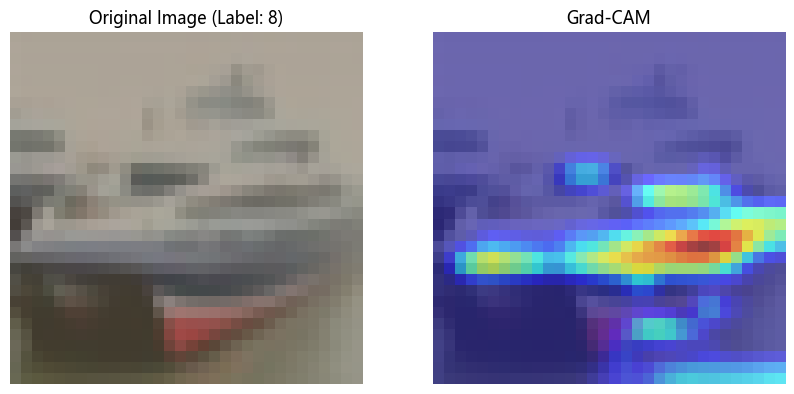

In [31]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from Grad_cam import GradCAM, show_cam_on_image

def main():
    #  加载模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load("best_model.pth"))
    model.to(device)
    model.eval()
    
    #  选择目标层
    target_layers = [model.conv2]

    #  数据预处理
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 加载测试集图像（假设test_set已定义）
    img, label = test_set[1]  # 获取第二张图像
    
    # 预处理图像（如果test_set中的图像未预处理）
    if not isinstance(img, torch.Tensor):
        img = data_transform(img)
    input_tensor = img.unsqueeze(0).to(device)

    # Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
    
    # 直接使用类别索引作为目标
    grayscale_cam = cam(input_tensor=input_tensor, target_category=label)
    
    grayscale_cam = grayscale_cam[0, :]

    # 反归一化图像用于可视化
    img_for_show = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    img_for_show = img_for_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_for_show = np.clip(img_for_show, 0, 1)

    #  可视化
    visualization = show_cam_on_image(img_for_show, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_for_show)
    plt.title(f"Original Image (Label: {label})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()


main()

In [ ]:
# import torch.optim as optim
# from torchvision.models import resnet18
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model = CIFAR10_CNN().to(device)

# model = resnet18(pretrained=True).to(device)
# model.fc = nn.Linear(model.fc.in_features, 10)  # 替换最后一层
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# for epoch in range(20):
#     model.train()
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # 每个epoch后验证精度
#     model.eval()
#     correct = 0
#     with torch.no_grad():
#         for images, labels in test_loader:
#             outputs = model(images.to(device))
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels.to(device)).sum().item()
#     print(f"Epoch {epoch+1}: Test Acc = {100 * correct / len(test_set):.2f}%")